In [1]:
# Basic imports
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd

import kaggle_support as kgs
import pack_cost
import pack_minkowski as mink
import pack_vis_sol

print("Imports complete")

local
Imports complete


In [2]:
# Generate 2000 2-tree test cases
np.random.seed(42)
N_test_cases = 2000
N_trees = 2

# Random positions: (dx, dy) pairs between trees
# Generate relative separations in a reasonable range
# Tree 1 at origin, Tree 2 at various positions
dx = np.random.uniform(-0.5, 0.5, N_test_cases)
dy = np.random.uniform(-0.5, 0.5, N_test_cases)

# Random rotation angles for tree 2 (tree 1 always at theta=0)
theta2 = np.random.uniform(0, 2*np.pi, N_test_cases)

print(f"Generated {N_test_cases} test cases")
print(f"dx range: [{dx.min():.3f}, {dx.max():.3f}]")
print(f"dy range: [{dy.min():.3f}, {dy.max():.3f}]")
print(f"theta2 range: [{theta2.min():.3f}, {theta2.max():.3f}]")

Generated 2000 test cases
dx range: [-0.497, 0.500]
dy range: [-0.500, 0.500]
theta2 range: [0.000, 6.279]


In [3]:
def compute_exact_separation(dx: np.ndarray, dy: np.ndarray, theta2: np.ndarray) -> np.ndarray:
    """
    Compute exact (non-discretized) separation distance using pack_minkowski directly.
    
    Parameters
    ----------
    dx : np.ndarray
        X separation between trees (shape: N,)
    dy : np.ndarray
        Y separation between trees (shape: N,)
    theta2 : np.ndarray
        Rotation angle of tree 2 in radians (shape: N,)
        
    Returns
    -------
    cost : np.ndarray
        Cost values for each test case (shape: N,)
        Applies max(0, separation)^2 transform to raw distances
    """
    N = len(dx)
    costs = np.zeros(N)
    
    # Tree 1 always at origin with rotation 0
    tree1_pos = (0.0, 0.0)
    
    # Process each test case
    # We need to call separation_distance for each unique theta2
    unique_thetas = np.unique(theta2)
    
    for theta in unique_thetas:
        # Find all test cases with this theta
        mask = theta2 == theta
        indices = np.where(mask)[0]
        
        # Get tree2 positions for this theta
        tree2_positions = np.column_stack([dx[mask], dy[mask]])  # (n, 2)
        
        # Compute separation distances (vectorized for this theta)
        sep_distances = mink.separation_distance(tree1_pos, tree2_positions, theta)
        
        # Apply cost transform: max(0, sep)^2
        costs[indices] = np.maximum(0, sep_distances) ** 2
    
    return costs

In [4]:
def compute_discretized_separation(dx: np.ndarray, dy: np.ndarray, theta2: np.ndarray,
                                   Nx: int, Ny: int, Ntheta: int) -> np.ndarray:
    """
    Compute discretized separation distance using CollisionCostExactSeparation with lookup table.
    
    This is a wrapper around pack_cost.CollisionCostExactSeparation that creates
    a lookup table and evaluates the cost.
    
    Parameters
    ----------
    dx : np.ndarray
        X separation between trees (shape: N,)
    dy : np.ndarray
        Y separation between trees (shape: N,)
    theta2 : np.ndarray
        Rotation angle of tree 2 in radians (shape: N,)
    Nx : int
        Number of discretization points in X
    Ny : int
        Number of discretization points in Y
    Ntheta : int
        Number of discretization points in theta
        
    Returns
    -------
    cost : np.ndarray
        Cost values for each test case (shape: N,)
    """
    N = len(dx)
    
    # Create cost function with lookup table
    cost_fn = pack_cost.CollisionCostExactSeparation(
        scaling=1.0,
        use_lookup_table=True,
        lut_N_x=Nx,
        lut_N_y=Ny,
        lut_N_theta=Ntheta,
        lut_trim_zeros=False
    )
    
    # Create a solution collection with 2 trees for each test case
    # Tree 1 at origin with theta=0, Tree 2 at (dx, dy) with theta=theta2
    xyt = cp.zeros((N, 2, 3), dtype=cp.float32)
    xyt[:, 0, :] = cp.array([0.0, 0.0, 0.0], dtype=cp.float32)  # Tree 1 at origin, no rotation
    xyt[:, 1, 0] = cp.asarray(dx, dtype=cp.float32)              # Tree 2 x position
    xyt[:, 1, 1] = cp.asarray(dy, dtype=cp.float32)              # Tree 2 y position
    xyt[:, 1, 2] = cp.asarray(theta2, dtype=cp.float32)          # Tree 2 rotation
    
    # Create solution collection (using square boundary with large size)
    # Boundary parameters don't matter for pairwise collision cost
    h = cp.ones((N, 3), dtype=cp.float32) * 100.0  # Large boundary
    
    solution = kgs.SolutionCollectionSquare(
        xyt=xyt,
        h=h,
        periodic=False
    )
    
    # Compute cost using the proper method
    cost, grad_xyt, grad_h = cost_fn.compute_cost_allocate(solution, evaluate_gradient=False)
    
    # Return only the cost for each test case
    return cost.get()

In [5]:
# Test the functions with a small example
test_dx = dx[:10]
test_dy = dy[:10]
test_theta = theta2[:10]

print("Testing exact separation function...")
exact_costs = compute_exact_separation(test_dx, test_dy, test_theta)
print(f"Exact costs (first 10): {exact_costs}")

print("\nTesting discretized separation function (CUDA)...")
discretized_costs = compute_discretized_separation(test_dx, test_dy, test_theta,
                                                    Nx=100, Ny=100, Ntheta=100)
print(f"Discretized costs (first 10): {discretized_costs}")

print("\nComparison (first 10):")
for i in range(10):
    print(f"  Case {i}: exact={exact_costs[i]:.6f}, CUDA={discretized_costs[i]:.6f}, "
          f"CUDA_err={abs(exact_costs[i] - discretized_costs[i]):.6e}, "
          f"x")

Testing exact separation function...
Exact costs (first 10): [0.11919857 0.01883901 0.07535174 0.14145994 0.03419329 0.04022005
 0.03335903 0.04157878 0.05526855 0.09470103]

Testing discretized separation function (CUDA)...
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt100_trimFalse_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local/cuda/bin/../ta

Computing exact costs for all test cases...
Exact costs computed: min=0.000000, max=0.377204

Starting sweep over 10 x 10 = 100 configurations...
This may take some time as lookup tables are built...

Testing N_xy=50, N_theta=50... Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt50_trimFalse_tree116323fb.lut_cache...
Successfully loaded cached lookup table
x1 0.055795673
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt50_trimFalse_tree116323fb.lut_cache...
Successfully loaded cached lookup table
x2 0.055795673
Time: 0.01s, Mean abs error: 1.122417e-03, Max abs error: 2.334842e-02
Testing N_xy=50, N_theta=100... Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt100_trimFalse_tree116323fb.lut_cache...
Successfully loaded cached lookup table
x1 0.055770587
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt100_trimFalse_tree116323fb.lut_cac

<Figure size 800x800 with 0 Axes>

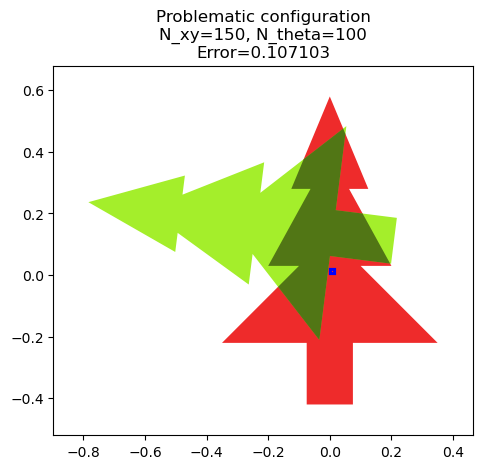

ValueError: Discretization error 0.107103 exceeds threshold 0.1

In [6]:
# Sweep over discretization parameters
# Nx = Ny varies from 50 to 500, with Ntheta also varying

import time

# Define sweep parameters
N_xy_values = np.arange(50,501,50)
N_theta_values = np.arange(50,501,50)

# Use all 2000 test cases for error statistics
sweep_dx = dx
sweep_dy = dy
sweep_theta = theta2

# Compute exact costs once (reference)
print("Computing exact costs for all test cases...")
exact_sweep_costs = compute_exact_separation(sweep_dx, sweep_dy, sweep_theta)
print(f"Exact costs computed: min={exact_sweep_costs.min():.6f}, max={exact_sweep_costs.max():.6f}")

# Store results
results = []

print(f"\nStarting sweep over {len(N_xy_values)} x {len(N_theta_values)} = {len(N_xy_values)*len(N_theta_values)} configurations...")
print("This may take some time as lookup tables are built...\n")

for N_xy in N_xy_values:
    for N_theta in N_theta_values:
        print(f"Testing N_xy={N_xy}, N_theta={N_theta}...", end=" ", flush=True)
        
        t_start = time.time()
        
        # Compute discretized costs
        discretized_sweep_costs = compute_discretized_separation(
            sweep_dx, sweep_dy, sweep_theta,
            Nx=N_xy, Ny=N_xy, Ntheta=N_theta
        )
        print('x1', discretized_sweep_costs[8])
        discretized_sweep_costs = compute_discretized_separation(
            sweep_dx, sweep_dy, sweep_theta,
            Nx=N_xy, Ny=N_xy, Ntheta=N_theta
        )
        print('x2', discretized_sweep_costs[8])
        # discretized_sweep_costs = compute_discretized_separation(
        #     sweep_dx, sweep_dy, sweep_theta,
        #     Nx=N_xy, Ny=N_xy, Ntheta=N_theta
        # )
        # print('x3', discretized_sweep_costs[9])
        
        t_elapsed = time.time() - t_start
        
        # Compute error metrics
        abs_errors = np.abs(exact_sweep_costs - discretized_sweep_costs)
        rel_errors = abs_errors / (exact_sweep_costs + 1e-10)  # Add small epsilon to avoid division by zero
        
        # Check for large errors (>0.1)
        large_error_mask = abs_errors > 0.1
        if np.any(large_error_mask):
            # Find first case with large error
            error_idx = np.where(large_error_mask)[0][0]
            
            print(f"\n\nERROR: Large discretization error detected!")
            print(f"Configuration: N_xy={N_xy}, N_theta={N_theta}")
            print(f"Test case index: {error_idx}")
            print(f"x = {sweep_dx[error_idx]:.6f}")
            print(f"y = {sweep_dy[error_idx]:.6f}")
            print(f"theta = {sweep_theta[error_idx]:.6f} rad ({np.degrees(sweep_theta[error_idx]):.2f} deg)")
            print(f"Exact cost: {exact_sweep_costs[error_idx]:.6f}")
            print(f"Discretized cost: {discretized_sweep_costs[error_idx]:.6f}")
            print(f"Absolute error: {abs_errors[error_idx]:.6f}")
            
            # Get the 8 nearest grid points in the lookup table
            # Need to access the cost function's LUT
            cost_fn_debug = pack_cost.CollisionCostExactSeparation(
                scaling=1.0,
                use_lookup_table=True,
                lut_N_x=N_xy,
                lut_N_y=N_xy,
                lut_N_theta=N_theta,
                lut_trim_zeros=False
            )
            # Initialize LUT
            xyt_dummy = cp.zeros((1, 2, 3), dtype=cp.float32)
            h_dummy = cp.ones((1, 1), dtype=cp.float32) * 100.0
            sol_dummy = kgs.SolutionCollectionSquare(xyt=xyt_dummy, h=h_dummy, periodic=False)
            _, _, _ = cost_fn_debug.compute_cost_allocate(sol_dummy, evaluate_gradient=False)
            
            # Access the LUT
            lut = cost_fn_debug._lut
            
            # Find the 8 nearest grid points (corners of interpolation cube)
            x_val = sweep_dx[error_idx]
            y_val = sweep_dy[error_idx]
            theta_val = sweep_theta[error_idx]
            
            # Find grid indices (floor and ceil)
            x_idx = np.searchsorted(lut.X, x_val) - 1
            x_idx = max(0, min(x_idx, len(lut.X) - 2))
            x_idx_low, x_idx_high = x_idx, x_idx + 1
            
            y_idx = np.searchsorted(lut.Y, y_val) - 1
            y_idx = max(0, min(y_idx, len(lut.Y) - 2))
            y_idx_low, y_idx_high = y_idx, y_idx + 1
            
            theta_idx = np.searchsorted(lut.theta, theta_val) - 1
            theta_idx = max(0, min(theta_idx, len(lut.theta) - 2))
            theta_idx_low, theta_idx_high = theta_idx, theta_idx + 1
            
            print(f"\n8 nearest grid points:")
            print(f"Query point: x={x_val:.6f}, y={y_val:.6f}, theta={theta_val:.6f}")
            print(f"Grid indices: x=[{x_idx_low}, {x_idx_high}], y=[{y_idx_low}, {y_idx_high}], theta=[{theta_idx_low}, {theta_idx_high}]")
            print(f"\n{'Corner':<10} {'X':>10} {'Y':>10} {'Theta':>10} {'LUT_raw':>12} {'LUT_cost':>12}")
            
            for xi, x_i in enumerate([x_idx_low, x_idx_high]):
                for yi, y_i in enumerate([y_idx_low, y_idx_high]):
                    for ti, t_i in enumerate([theta_idx_low, theta_idx_high]):
                        x_grid = lut.X[x_i]
                        y_grid = lut.Y[y_i]
                        theta_grid = lut.theta[t_i]
                        
                        # LUT value (before quadratic transform - raw separation distance)
                        lut_val_raw = lut.vals[x_i, y_i, t_i]
                        # Apply quadratic transform
                        lut_val_cost = np.maximum(0, lut_val_raw) ** 2
                        
                        corner_label = f"({xi},{yi},{ti})"
                        print(f"{corner_label:<10} {x_grid:>10.6f} {y_grid:>10.6f} {theta_grid:>10.6f} {lut_val_raw:>12.6f} {lut_val_cost:>12.6f}")
            
            # Recompute discretized cost via pack_cost class (standard path)
            print(f"\nRecomputing via pack_cost class:")
            xyt_single = cp.zeros((1, 2, 3), dtype=cp.float32)
            xyt_single[0, 0, :] = cp.array([0.0, 0.0, 0.0], dtype=cp.float32)
            xyt_single[0, 1, 0] = cp.float32(sweep_dx[error_idx])
            xyt_single[0, 1, 1] = cp.float32(sweep_dy[error_idx])
            xyt_single[0, 1, 2] = cp.float32(sweep_theta[error_idx])
            h_single = cp.ones((1, 1), dtype=cp.float32) * 100.0
            sol_single = kgs.SolutionCollectionSquare(xyt=xyt_single, h=h_single, periodic=False)
            
            cost_recomputed_standard, _, _ = cost_fn_debug.compute_cost_allocate(sol_single, evaluate_gradient=False)
            cost_recomputed_standard = cost_recomputed_standard.get()[0]
            print(f"Pack_cost class cost: {cost_recomputed_standard:.6f}")
            
            # Now recompute with direct CUDA kernel call with debug output
            print(f"\nRecomputing via direct CUDA kernel (with debug output):")
            import pack_cuda_lut
            cost_array = cp.zeros(1, dtype=cp.float32)
            debug_buf = pack_cuda_lut.overlap_multi_ensemble(
                sol_single.xyt, cost_array, cost_fn_debug._lut,
                debug_solution_idx=0, debug_pair_idx=1)
            cost_recomputed_cuda = cost_array.get()[0]
            print(f"Direct CUDA kernel cost: {cost_recomputed_cuda:.6f}")
            
            # Recompute via wrapper function compute_discretized_separation (full batch, same as sweep)
            print(f"\nRecomputing via compute_discretized_separation wrapper (full batch):")
            cost_recomputed_wrapper_full = compute_discretized_separation(
                sweep_dx, sweep_dy, sweep_theta,
                Nx=N_xy, Ny=N_xy, Ntheta=N_theta
            )
            cost_recomputed_wrapper = cost_recomputed_wrapper_full[error_idx]
            print(f"Wrapper function cost[{error_idx}]: {cost_recomputed_wrapper:.6f}")
            
            # Recompute via pack_cost on WHOLE solution, then extract error_idx
            print(f"\nRecomputing via pack_cost on full batch:")
            xyt_full = cp.zeros((N_test_cases, 2, 3), dtype=cp.float32)
            xyt_full[:, 0, :] = cp.array([0.0, 0.0, 0.0], dtype=cp.float32)
            xyt_full[:, 1, 0] = cp.asarray(sweep_dx, dtype=cp.float32)
            xyt_full[:, 1, 1] = cp.asarray(sweep_dy, dtype=cp.float32)
            xyt_full[:, 1, 2] = cp.asarray(sweep_theta, dtype=cp.float32)
            h_full = cp.ones((N_test_cases, 1), dtype=cp.float32) * 100.0
            sol_full = kgs.SolutionCollectionSquare(xyt=xyt_full, h=h_full, periodic=False)
            
            cost_full_batch, _, _ = cost_fn_debug.compute_cost_allocate(sol_full, evaluate_gradient=False)
            cost_recomputed_batch = cost_full_batch.get()[error_idx]
            print(f"Batch computation cost[{error_idx}]: {cost_recomputed_batch:.6f}")
            
            print(f"\nComparison of all methods:")
            print(f"  1. Original discretized cost:     {discretized_sweep_costs[error_idx]:.6f}")
            print(f"  2. Pack_cost (single):            {cost_recomputed_standard:.6f}  (diff: {abs(discretized_sweep_costs[error_idx] - cost_recomputed_standard):.6e})")
            print(f"  3. CUDA kernel (single+debug):    {cost_recomputed_cuda:.6f}  (diff: {abs(discretized_sweep_costs[error_idx] - cost_recomputed_cuda):.6e})")
            print(f"  4. Wrapper function (single):     {cost_recomputed_wrapper:.6f}  (diff: {abs(discretized_sweep_costs[error_idx] - cost_recomputed_wrapper):.6e})")
            print(f"  5. Pack_cost batch[{error_idx}]:        {cost_recomputed_batch:.6f}  (diff: {abs(discretized_sweep_costs[error_idx] - cost_recomputed_batch):.6e})")
            print(f"\n  Max pairwise difference: {max(abs(discretized_sweep_costs[error_idx] - cost_recomputed_standard), abs(discretized_sweep_costs[error_idx] - cost_recomputed_cuda), abs(discretized_sweep_costs[error_idx] - cost_recomputed_wrapper), abs(discretized_sweep_costs[error_idx] - cost_recomputed_batch)):.6e}")
            
            # Decode debug buffer
            if debug_buf is not None:
                debug_data = debug_buf.get()
                print(f"\nCUDA Kernel Debug Output:")
                print(f"  Query point: x={debug_data[0]:.6f}, y={debug_data[1]:.6f}, theta={debug_data[2]:.6f}")
                print(f"  Grid indices: ix=[{int(debug_data[3])}, {int(debug_data[4])}], "
                      f"iy=[{int(debug_data[5])}, {int(debug_data[6])}], "
                      f"itheta=[{int(debug_data[7])}, {int(debug_data[8])}]")
                print(f"  Interpolation weights: wx={debug_data[9]:.6f}, wy={debug_data[10]:.6f}, wtheta={debug_data[11]:.6f}")
                print(f"\n  LUT corner values (raw):")
                corner_labels = ['(0,0,0)', '(0,0,1)', '(0,1,0)', '(0,1,1)', 
                                 '(1,0,0)', '(1,0,1)', '(1,1,0)', '(1,1,1)']
                for i, label in enumerate(corner_labels):
                    corner_val = debug_data[12 + i]
                    corner_cost = np.maximum(0, corner_val) ** 2
                    print(f"    {label}: {corner_val:.6f} (cost: {corner_cost:.6f})")
                print(f"\n  Interpolated raw value: {debug_data[20]:.6f}")
                print(f"  Final transformed cost: {debug_data[21]:.6f}")
            
            # Visualize the problematic configuration
            # Create solution with 2 trees at the problematic configuration
            xyt_vis = cp.zeros((1, 2, 3), dtype=cp.float32)
            xyt_vis[0, 0, :] = cp.array([0.0, 0.0, 0.0], dtype=cp.float32)  # Tree 1 at origin
            xyt_vis[0, 1, 0] = cp.float32(sweep_dx[error_idx])
            xyt_vis[0, 1, 1] = cp.float32(sweep_dy[error_idx])
            xyt_vis[0, 1, 2] = cp.float32(sweep_theta[error_idx])
            
            # For SolutionCollectionSquare, h only has 1 column (half-width)
            h_vis = cp.ones((1, 3), dtype=cp.float32) * 0.01
            
            sol_vis = kgs.SolutionCollectionSquare(
                xyt=xyt_vis,
                h=h_vis,
                periodic=False
            )

            sol_vis.check_constraints()
            
            plt.figure(figsize=(8, 8))
            pack_vis_sol.pack_vis_sol(sol_vis, solution_idx=0)
            plt.title(f'Problematic configuration\nN_xy={N_xy}, N_theta={N_theta}\nError={abs_errors[error_idx]:.6f}')
            plt.show()
            
            raise ValueError(f"Discretization error {abs_errors[error_idx]:.6f} exceeds threshold 0.1")
        
        result = {
            'N_xy': N_xy,
            'N_theta': N_theta,
            'N_total': N_xy * N_xy * N_theta,
            'time_s': t_elapsed,
            'mean_abs_error': abs_errors.mean(),
            'median_abs_error': np.median(abs_errors),
            'max_abs_error': abs_errors.max(),
            'p95_abs_error': np.percentile(abs_errors, 95),
            'mean_rel_error': rel_errors.mean(),
            'median_rel_error': np.median(rel_errors),
            'max_rel_error': rel_errors.max(),
            'p95_rel_error': np.percentile(rel_errors, 95),
        }
        
        results.append(result)
        
        print(f"Time: {t_elapsed:.2f}s, Mean abs error: {result['mean_abs_error']:.6e}, Max abs error: {result['max_abs_error']:.6e}")

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nSweep complete! {len(df_results)} configurations tested.")
df_results

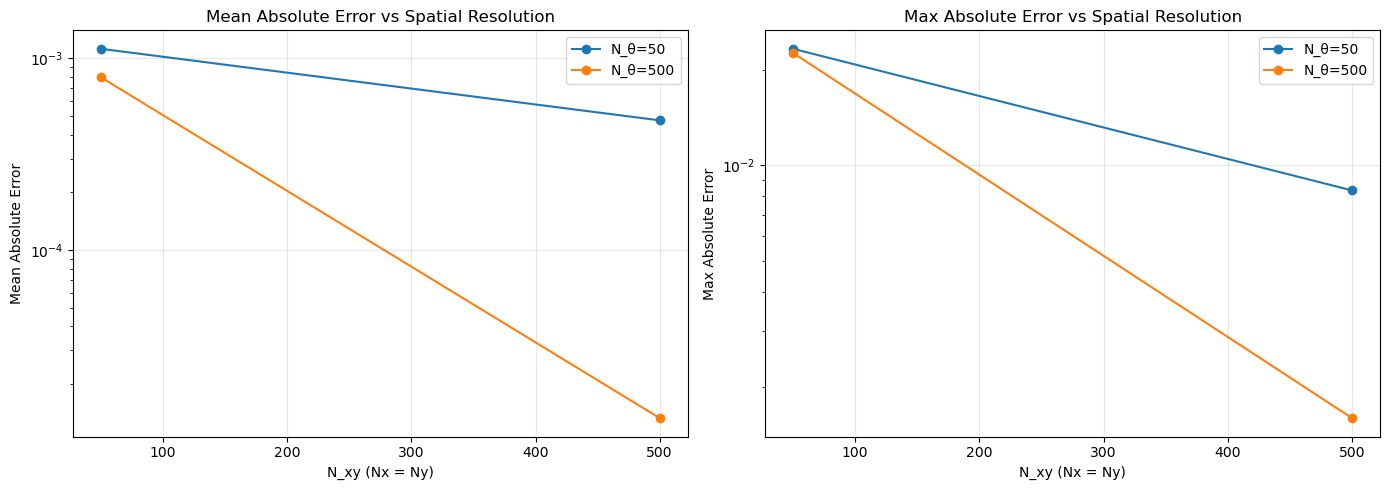

In [ ]:
# Visualize results: Mean absolute error vs grid size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean absolute error for different N_theta values
ax = axes[0]
for N_theta in sorted(df_results['N_theta'].unique()):
    subset = df_results[df_results['N_theta'] == N_theta]
    ax.plot(subset['N_xy'], subset['mean_abs_error'], marker='o', label=f'N_θ={N_theta}')
ax.set_xlabel('N_xy (Nx = Ny)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Mean Absolute Error vs Spatial Resolution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 2: Max absolute error for different N_theta values
ax = axes[1]
for N_theta in sorted(df_results['N_theta'].unique()):
    subset = df_results[df_results['N_theta'] == N_theta]
    ax.plot(subset['N_xy'], subset['max_abs_error'], marker='o', label=f'N_θ={N_theta}')
ax.set_xlabel('N_xy (Nx = Ny)')
ax.set_ylabel('Max Absolute Error')
ax.set_title('Max Absolute Error vs Spatial Resolution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

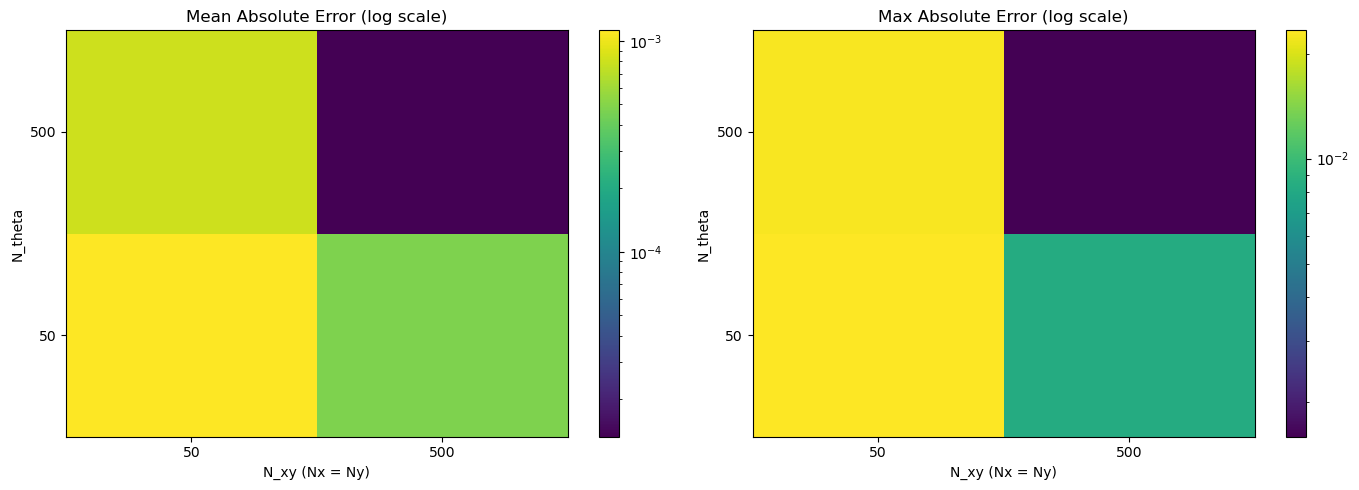

In [ ]:
# Heatmap visualization: Mean absolute error as function of N_xy and N_theta
pivot_mean = df_results.pivot(index='N_theta', columns='N_xy', values='mean_abs_error')
pivot_max = df_results.pivot(index='N_theta', columns='N_xy', values='max_abs_error')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap 1: Mean absolute error
im1 = axes[0].imshow(pivot_mean.values, aspect='auto', cmap='viridis', origin='lower', norm=plt.matplotlib.colors.LogNorm())
axes[0].set_xticks(range(len(pivot_mean.columns)))
axes[0].set_xticklabels(pivot_mean.columns)
axes[0].set_yticks(range(len(pivot_mean.index)))
axes[0].set_yticklabels(pivot_mean.index)
axes[0].set_xlabel('N_xy (Nx = Ny)')
axes[0].set_ylabel('N_theta')
axes[0].set_title('Mean Absolute Error (log scale)')
plt.colorbar(im1, ax=axes[0])

# Heatmap 2: Max absolute error
im2 = axes[1].imshow(pivot_max.values, aspect='auto', cmap='viridis', origin='lower', norm=plt.matplotlib.colors.LogNorm())
axes[1].set_xticks(range(len(pivot_max.columns)))
axes[1].set_xticklabels(pivot_max.columns)
axes[1].set_yticks(range(len(pivot_max.index)))
axes[1].set_yticklabels(pivot_max.index)
axes[1].set_xlabel('N_xy (Nx = Ny)')
axes[1].set_ylabel('N_theta')
axes[1].set_title('Max Absolute Error (log scale)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# Save results to CSV for later analysis
output_file = 'discretization_error_results.csv'
df_results.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

# Display summary statistics
print("\nTop 10 configurations by mean absolute error:")
print(df_results.nsmallest(10, 'mean_abs_error')[['N_xy', 'N_theta', 'N_total', 'mean_abs_error', 'max_abs_error', 'time_s']])

Results saved to discretization_error_results.csv

Top 10 configurations by mean absolute error:
   N_xy  N_theta    N_total  mean_abs_error  max_abs_error    time_s
0    50       50     125000        0.001122       0.023348  0.009042
1    50      500    1250000        0.072143       0.377204  0.026838
2   500       50   12500000        0.072317       0.377204  0.209061
3   500      500  125000000        0.080142       0.377204  1.989149


In [ ]:
lut.theta

array([-3.1415927 , -3.0133643 , -2.8851361 , -2.756908  , -2.6286795 ,
       -2.5004513 , -2.3722231 , -2.2439947 , -2.1157665 , -1.9875382 ,
       -1.8593099 , -1.7310817 , -1.6028534 , -1.4746251 , -1.3463968 ,
       -1.2181686 , -1.0899403 , -0.96171206, -0.83348376, -0.7052555 ,
       -0.5770272 , -0.44879895, -0.32057068, -0.1923424 , -0.06411414,
        0.06411414,  0.1923424 ,  0.32057068,  0.44879895,  0.5770272 ,
        0.7052555 ,  0.83348376,  0.96171206,  1.0899403 ,  1.2181686 ,
        1.3463968 ,  1.4746251 ,  1.6028534 ,  1.7310817 ,  1.8593099 ,
        1.9875382 ,  2.1157665 ,  2.2439947 ,  2.3722231 ,  2.5004513 ,
        2.6286795 ,  2.756908  ,  2.8851361 ,  3.0133643 ,  3.1415927 ],
      dtype=float32)

In [ ]:
theta_idx_low

49

In [ ]:
theta_idx_high

49

In [ ]:
error_idx

np.int64(8)